# Load the two datasets: one in dbtropes_dataset and the other in tropescraper_datasets

- If you don't have access to the dbtropes file, please download it from: http://skipforward.opendfki.de/wiki/DBTropes and unzip it. Then copy the path.
- If you don't have access to the tropescraper-generated file, please run tropescraper and copy the path.
- Use the dbtropes_dataset and tropescraper_dataset as mappings from films to tropes: [film]->[trope_1,...,trope_n]
- Use the dbtropes_dataset_reversed and tropescraper_dataset_reversed as mappings from films to tropes: [trope]->[film_1,...,film_n]

In [89]:
DBTROPES_GENERATED_FILE_PATH = '/Users/phd/Downloads/dbtropes/dbtropes-20160701.nt'
TROPESCRAPER_GENERATED_FILE_PATH = '/Users/phd/workspace/made/tropescraper/bin/tvtropes.json'

Useful functions

In [100]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy import stats
import pandas as pd
from scipy import stats
import re
from IPython.display import clear_output

BINS = 100
FIGURE_SIZE = [12,5]

def reverse_mapping(mapping):
    reverse_map = {}
    for key in mapping.keys():
        for value in mapping[key]:
            if value not in reverse_map:
                reverse_map[value] = []
            reverse_map[value].append(key)
    return reverse_map

def descriptive_analysis(what, dbtropes_values, tropescraper_values):
    dbtropes_stats = stats.describe(dbtropes_values)
    tropescraper_stats = stats.describe(tropescraper_values)
    dataframe = pd.DataFrame.from_dict({
        'min':[dbtropes_stats.minmax[0],tropescraper_stats.minmax[0]],
        'max':[dbtropes_stats.minmax[1], tropescraper_stats.minmax[1]],
        'nobs':[dbtropes_stats.nobs, tropescraper_stats.nobs],
        'mean':[dbtropes_stats.mean, tropescraper_stats.mean],
        'kurtosis':[dbtropes_stats.kurtosis, tropescraper_stats.kurtosis],
        'skewness':[dbtropes_stats.skewness, tropescraper_stats.skewness],
        'variance':[dbtropes_stats.variance, tropescraper_stats.variance]
    }, orient='index')
    dataframe.columns = ['DBTropes', 'tropescraper']
    display(HTML(dataframe.to_html()))

    plt.rcParams['figure.figsize'] = FIGURE_SIZE
    dataframe.plot.bar()
    plt.title(f'Descriptive analysis {what} comparison')
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].set_title(f'DBTropes {what} histogram (log scale)')
    axes[0].set_yscale('log')
    axes[1].set_title(f'tropescraper {what} histogram (log scale)')
    axes[1].set_yscale('log')
    dataframe = pd.DataFrame.from_dict({'values':dbtropes_values})
    dataframe.plot.hist(bins=BINS, ax=axes[0])
    dataframe = pd.DataFrame.from_dict({'values':tropescraper_values})
    dataframe.plot.hist(bins=BINS, ax=axes[1], color = "darkorange")

## Load the dbtropes dataset

Sample line in the nt file:

```<http://dbtropes.org/resource/Film/MenInBlack> <http://skipforward.net/skipforward/resource/seeder/skipinions/hasFeature> <http://dbtropes.org/resource/Main/NotQuiteDead/int_c3cae421> .```

In [96]:
template = '^<http://dbtropes.org/resource/Film/([^>]+)> <http://skipforward.net/skipforward/resource/seeder/skipinions/hasFeature> <http://dbtropes.org/resource/Main/([^/]+)/[^>/]+>.*$'
dbtropes_dataset = {}
dbtropes_films = set()
dbtropes_tropes = set()

with open(DBTROPES_GENERATED_FILE_PATH, 'r') as bdtropes_file:
    line = bdtropes_file.readline()
    counter = 1
    while line:
        matches = re.match(template, line)
        if matches:
            film = matches.group(1)
            dbtropes_films.add(film)
            
            trope = matches.group(2)
            dbtropes_tropes.add(trope)
            
            if film not in dbtropes_dataset:
                dbtropes_dataset[film] = set()
            
            dbtropes_dataset[film].add(trope)
            
        line = bdtropes_file.readline()
        counter += 1
        
        if counter%100000 ==0:
            clear_output(wait = True)
            print(f'Lines processed = {counter:,}')

dbtropes_dataset_reversed = reverse_mapping(dbtropes_dataset)
            
clear_output(wait = True)
print(f'Summary: Lines = {counter-1:,}, Films count = {len(dbtropes_films):,}, '
      f'Tropes count = {len(dbtropes_tropes):,}')

Summary: Lines = 21,057,602, Films count = 6,296, Tropes count = 17,738


## Load the tropescraper dataset

In [97]:
import json

tropescraper_films = set()
tropescraper_tropes = set()

with open(TROPESCRAPER_GENERATED_FILE_PATH, 'r') as tropescraper_file:
    tropescraper_dataset = json.load(tropescraper_file)
    
tropescraper_films = set(dbtropes_dataset.keys())
for key in tropescraper_films:
    tropescraper_tropes.update(dbtropes_dataset[key])

tropescraper_dataset_reversed = reverse_mapping(tropescraper_dataset)

print(f'Summary: Films count = {len(tropescraper_films):,}, Tropes count = {len(tropescraper_tropes):,}')

Summary: Films count = 6,296, Tropes count = 17,738


# Descriptive analysis of the two datasets

## Number of Tropes

,DBTropes,tropescraper
min,1.000000,0.000000
max,1075.000000,971.000000
nobs,6296.000000,12147.000000
mean,21.984276,54.241623
kurtosis,85.791847,25.459101
skewness,7.046124,4.143250
variance,2164.167346,5526.764024


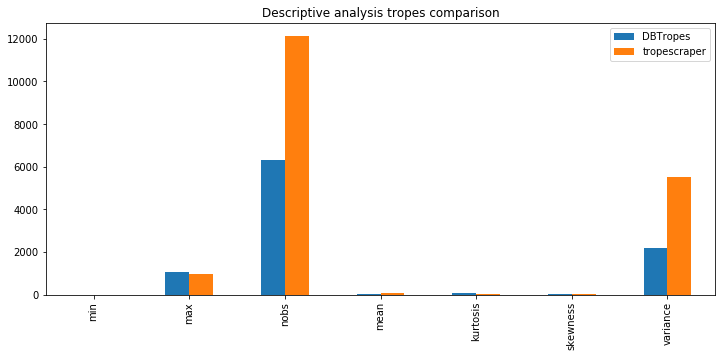

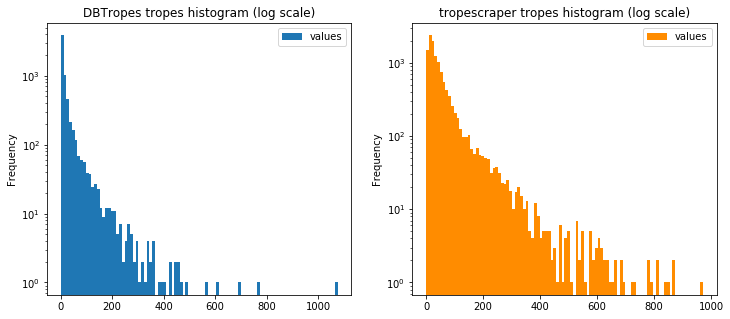

In [101]:
dbtropes_dataset_count_by_film = {film:len(dbtropes_dataset[film]) 
                                  for film in dbtropes_dataset.keys()}
tropescraper_dataset_count_by_film = {film:len(tropescraper_dataset[film]) 
                                      for film in tropescraper_dataset.keys()}

descriptive_analysis('tropes', list(dbtropes_dataset_count_by_film.values()), 
                     list(tropescraper_dataset_count_by_film.values()))

## Number of Films

,DBTropes,tropescraper
min,1.000000,1.000000
max,480.000000,3386.000000
nobs,17738.000000,26479.000000
mean,7.803191,24.882851
kurtosis,274.065379,326.595978
skewness,10.043485,13.551122
variance,117.915428,6506.852353


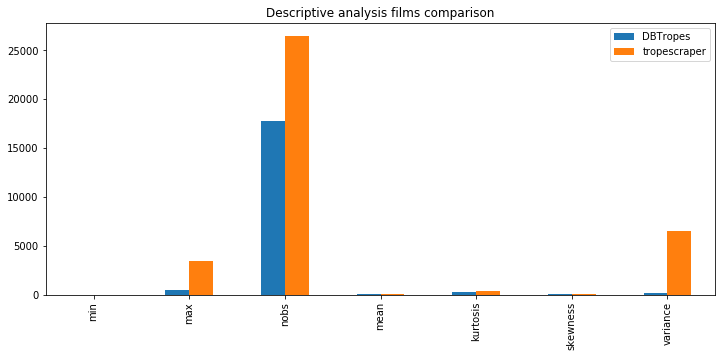

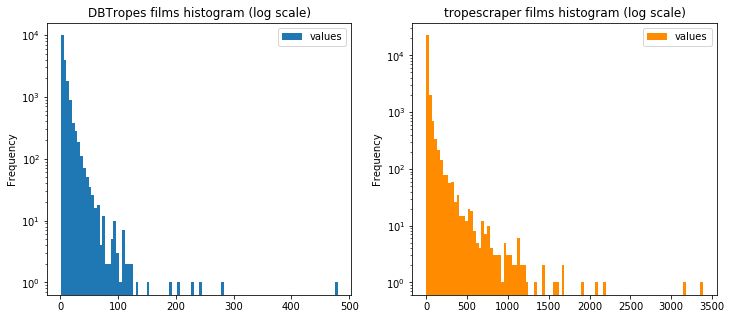

In [102]:
dbtropes_dataset_count_by_trope = {trope:len(dbtropes_dataset_reversed[trope]) 
                                   for trope in dbtropes_dataset_reversed.keys()}
tropescraper_dataset_count_by_trope = {trope:len(tropescraper_dataset_reversed[trope]) 
                                      for trope in tropescraper_dataset_reversed.keys()}

descriptive_analysis('films', list(dbtropes_dataset_count_by_trope.values()), 
                     list(tropescraper_dataset_count_by_trope.values()))